In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
from calendar import calendar
from tqdm import tqdm

from streamflow_generation import multi_site_nile_generator, read_historical_series
from IPython.display import clear_output
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
from array import array

In [3]:
read_historical_series("BlueNile")

,Date,BlueNile_m3|s
0,1960-01-31,445.700000
1,1960-02-29,236.800000
2,1960-03-31,161.600000
3,1960-04-30,137.400000
4,1960-05-31,190.300000
...,...,...
451,1997-08-31,4606.481481
452,1997-09-30,2565.586420
453,1997-10-31,1990.740741
454,1997-11-30,1574.074074


In [4]:
catchments_1 = ["BlueNile", "WhiteNile", "Atbara"]
catchments_2 = ["Rahad", "Dinder"]

for realization in tqdm(range(1000)):
    multi_site_nile_generator(
        [catchments_1, catchments_2],
        20,
        [realization, 100 + realization],
        realization,
        "drought_identification",
    )

  0%|          | 0/1000 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|██████████| 1000/1000 [00:36<00:00, 27.29it/s]


In [49]:
def divide_df(df, avgs, stds):

    flow = df.columns[-1]
    for i, row in df.iterrows():
        if stds[i % 12] != 0:
            df.loc[i, flow] = (df.loc[i, flow] - avgs[i % 12]) / stds[i % 12]
        else:
            df.loc[i, flow] = 0

    return df


def lognormalize_streamflows(streamflow_df):

    flow_name = streamflow_df.columns[-1]
    copy_df = streamflow_df.copy()

    # take logarithm
    problem_indices = copy_df[flow_name] < 1

    copy_df.loc[problem_indices, flow_name] = 1

    still_problem = copy_df.loc[copy_df[flow_name] < 1]
    #     print(still_problem.to_markdown())
    copy_df[flow_name] = pd.Series(np.log(copy_df[flow_name]))
    monthly_averages = []
    monthly_std = []
    
    copy_df = copy_df.reset_index()

    for i in range(0, 12):
        month_obs = copy_df.loc[copy_df.index % 12 == i, flow_name]
        monthly_averages.append(np.mean(month_obs))
        monthly_std.append(np.std(month_obs))

    return divide_df(copy_df, monthly_averages, monthly_std)


def findDroughts(streamflow_df, plotting=False):

    flow_name = streamflow_df.columns[-1]
    dates = pd.Series(streamflow_df.index)
    normalized_log_streamflow = np.array(
        lognormalize_streamflows(streamflow_df)[flow_name]
    )
    total_observations = len(normalized_log_streamflow)
    # first calculate the moving averages of 6 observations:

    numbers_series = pd.Series(normalized_log_streamflow)
    windows = numbers_series.rolling(6)
    moving_averages = windows.mean()
    # first 5 months will be NaN due to our window being 6, replace them with 0:
    moving_averages_list = moving_averages.fillna(0).tolist()

    # Now that we have the moving averages, let's apply the drought criterion:
    drought_period_indices = []
    flood_period_indices = []

    for i in range(6, total_observations):
        section_of_six = moving_averages_list[i - 6 : i]
        if all(map(lambda x: x < 0, section_of_six)) and any(
            map(lambda x: x < -1, section_of_six)
        ):
            drought_period_indices.append(i)
        elif all(map(lambda x: x > 0, section_of_six)) and any(
            map(lambda x: x > 11, section_of_six)
        ):
            flood_period_indices.append(i)
            
    print(drought_period_indices)
    print(flood_period_indices)

    if plotting:
        plt.plot(dates, moving_averages_list, color="black")
        # print(dates)
        # print([dates[x] for x in drought_period_indices])
        plt.vlines(
            x=[dates[x] for x in drought_period_indices], ymin=-2, ymax=2, colors="red"
        )
        plt.vlines(
            x=[dates[x] for x in flood_period_indices], ymin=-2, ymax=2, colors="blue"
        )
        plt.xlabel("Time", fontsize=14)
        plt.ylabel("SSI$_6$", fontsize=14)
        #plt.title(f"Drought investigation SSI6 criterion {flow_name}", fontsize=14)
        # plt.xticks(rotation='vertical', fontsize=18)
        plt.yticks(fontsize=14)
        plt.savefig("../plots/severe_drought_bluenile_ssi.pdf", bbox_inches="tight")
        plt.show()

    drought_groups = list()
    already_grouped = list()

    for i, dr_index in enumerate(drought_period_indices):
        if dr_index in already_grouped:
            continue
        current_group = [dr_index]
        j = i

        if not j == len(drought_period_indices) - 1:
            while drought_period_indices[j + 1] - drought_period_indices[j] == 1:
                current_group.append(drought_period_indices[j + 1])
                already_grouped.append(drought_period_indices[j + 1])
                j += 1
                if j == len(drought_period_indices) - 1:
                    break

        drought_groups.append(current_group)
        
    # Let's focus on years 5-15 -> index 60 to 180:
    specific_droughts = [drought for drought in drought_groups if drought[0] in range(60, 180)]
    specific_droughts_magnitude = list(
        map(lambda x: sum([moving_averages_list[i] for i in x]), specific_droughts)
    )
    sum_specific_droughts = np.nan_to_num(np.sum(specific_droughts_magnitude))

    drought_count = len(drought_groups)
    drought_magnitudes = list(
        map(lambda x: sum([moving_averages_list[i] for i in x]), drought_groups)
    )
    avg_magnitude = np.nan_to_num(np.mean(drought_magnitudes))
    drought_lengths = list(map(lambda x: len(x), drought_groups))
    avg_duration = np.nan_to_num(np.mean(drought_lengths))

    #     print(drought_groups)

    return drought_count, avg_magnitude, avg_duration, drought_groups, sum_specific_droughts

In [39]:
from datetime import datetime, timedelta

base = datetime(2023, 1, 1)
date_list = [base + timedelta(days=30.5 * x) for x in range(240)]

In [31]:
magnitudes = []
for i in tqdm(range(1000)):
    
    sample = pd.read_csv(f"../synthetic_hydrology/drought_identification/{i}.csv")
    sample["date"] = date_list
    small_df = sample.loc[:, ["BlueNile", "date"]].copy()
    small_df = small_df.set_index("date")
    magnitudes.append(findDroughts(small_df)[-1])


100%|██████████| 1000/1000 [00:42<00:00, 23.70it/s]


In [32]:
magnitudes.index(min(magnitudes))

630

[112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168]
[]


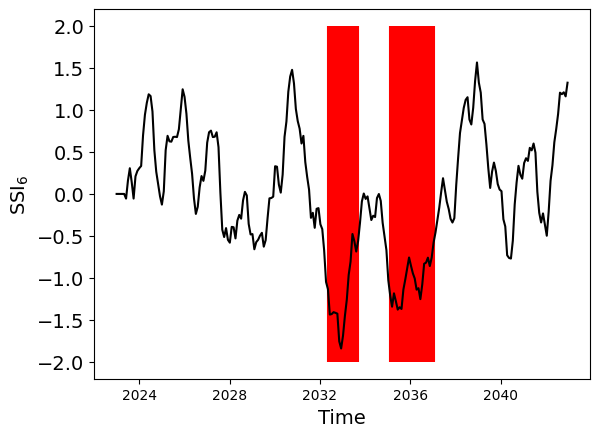

(2,
 -22.60300887267048,
 20.5,
 [[112,
   113,
   114,
   115,
   116,
   117,
   118,
   119,
   120,
   121,
   122,
   123,
   124,
   125,
   126,
   127,
   128],
  [145,
   146,
   147,
   148,
   149,
   150,
   151,
   152,
   153,
   154,
   155,
   156,
   157,
   158,
   159,
   160,
   161,
   162,
   163,
   164,
   165,
   166,
   167,
   168]],
 -45.20601774534096)

In [50]:
sample = pd.read_csv(f"../synthetic_hydrology/drought_identification/630.csv")
sample["date"] = date_list
small_df = sample.loc[:, ["BlueNile", "date"]].copy()
small_df = small_df.set_index("date")
findDroughts(small_df, True)

In [3]:
import importlib
# import plotter

import sys
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# importlib.reload(model.model_nile.ModelNile)

from model.model_nile import ModelNile
from output_analysis import plotter

new_model = ModelNile()
#full_return = new_model.evaluate(solutions[i])

In [4]:
len(new_model.synthetic_hydrology)

1

In [17]:
explored_policies = pd.read_csv("../outputs/policies_exploration.csv")
percent_compromise = list(explored_policies.loc[3])[:-1]
best_egypt = list(explored_policies.loc[0])[:-1]
best_ethiopia = list(explored_policies.loc[2])[:-1]

In [16]:
explored_policies

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v196,v197,v198,v199,v200,v201,v202,v203,v204,name
0,0.063787,0.456172,0.411468,0.963163,0.097215,0.673751,0.335214,-0.182279,0.442914,-0.658328,...,0.033796,0.401708,0.060981,0.139765,0.522041,0.731509,0.222838,0.486961,0.571622,Best Egypt Irrigation
1,0.056767,0.591496,0.643683,0.102761,0.030803,0.946503,0.987958,0.591314,0.784650,0.119132,...,0.454631,0.120220,0.607038,0.202289,1.000000,0.833729,0.339380,0.578749,0.760598,Best Egypt Minimum HAD Level
2,0.000000,0.214698,0.295648,0.523261,0.454980,1.000000,0.173753,-0.749664,0.004554,-0.715481,...,0.654952,0.777062,0.637723,0.355107,0.673061,0.534431,0.505371,0.275330,0.024209,Best Ethiopia Hydropower
3,0.056161,0.613539,0.510639,0.122278,0.093413,0.368321,0.775546,-0.874330,0.016318,-0.119696,...,0.781552,0.360561,0.211263,0.287920,0.160836,0.646485,0.488403,0.431947,0.609721,Compromise: Percentile Threshold
4,0.059883,0.650205,0.359965,0.122748,0.097466,0.979736,0.696491,-0.821580,0.107872,-0.155530,...,0.581126,0.178435,0.556094,0.556355,0.417923,0.522890,0.532429,0.723748,0.554375,Compromise: Absolute Threshold


In [11]:
full_return = new_model.evaluate(percent_compromise)

In [12]:
new_model.object_by_name("GERD").release_vector

array('f', [842.4598999023438, 843.2885131835938, 844.5713500976562, 853.4107666015625, 878.5777587890625, 919.7989501953125, 945.012939453125, 928.3760375976562, 884.1572875976562, 860.0047607421875, 850.0028686523438, 865.2344360351562, 883.3150024414062, 942.2984619140625, 1051.2275390625, 1160.691162109375, 1141.6632080078125, 1286.828857421875, 1396.6990966796875, 1234.7900390625, 952.9180297851562, 973.9794311523438, 1071.6405029296875, 1391.2364501953125, 1498.8885498046875, 1573.19677734375, 1631.71875, 1714.0274658203125, 1578.1861572265625, 1732.939208984375, 1739.3865966796875, 1436.3438720703125, 955.2767333984375, 940.3294677734375, 983.4541625976562, 1504.32421875, 1785.8634033203125, 1915.991943359375, 1918.12841796875, 1920.8458251953125, 1645.6834716796875, 1773.081298828125, 1901.894287109375, 1607.96337890625, 968.0130004882812, 874.9600830078125, 861.2108764648438, 920.7787475585938, 971.6299438476562, 911.4747314453125, 1032.9276123046875, 1186.3206787109375, 1396.

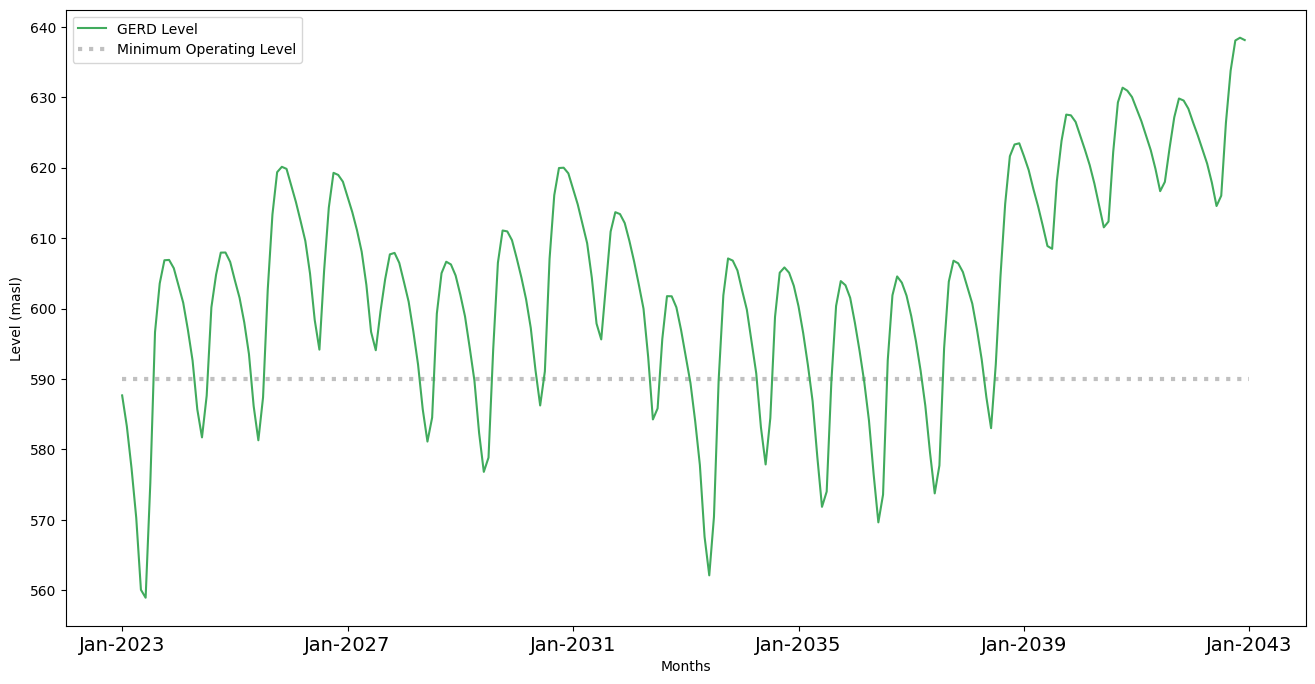

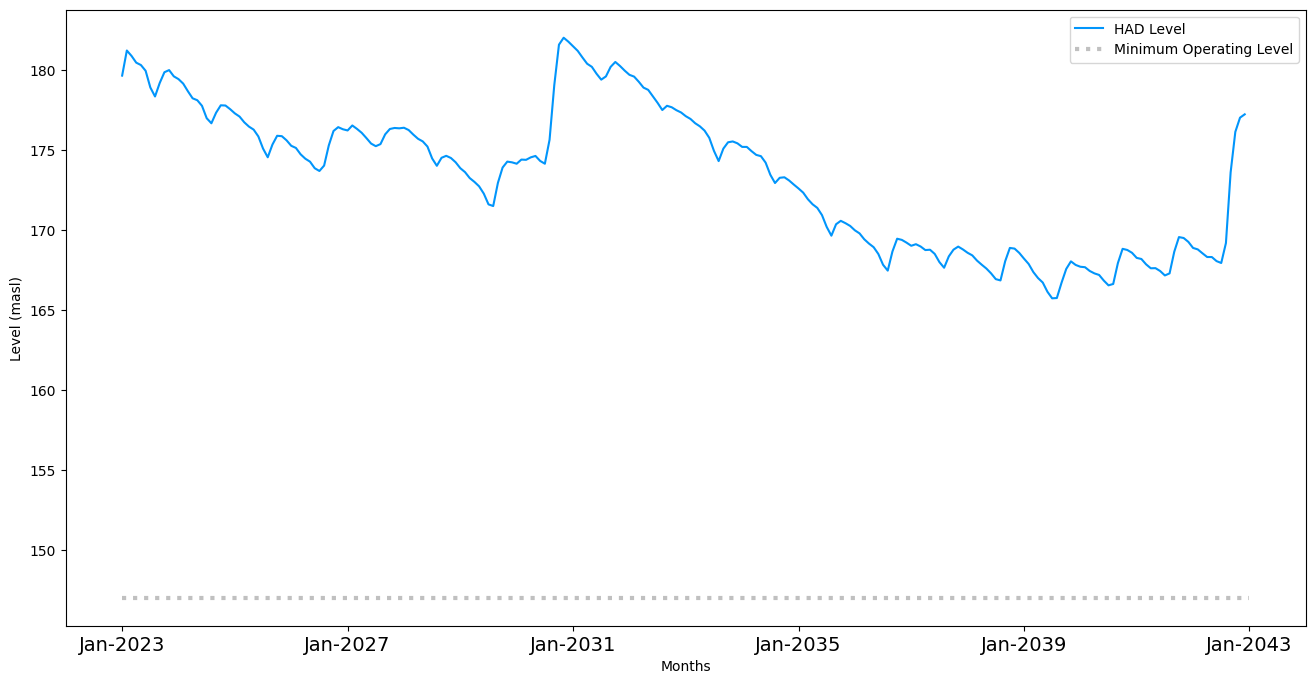

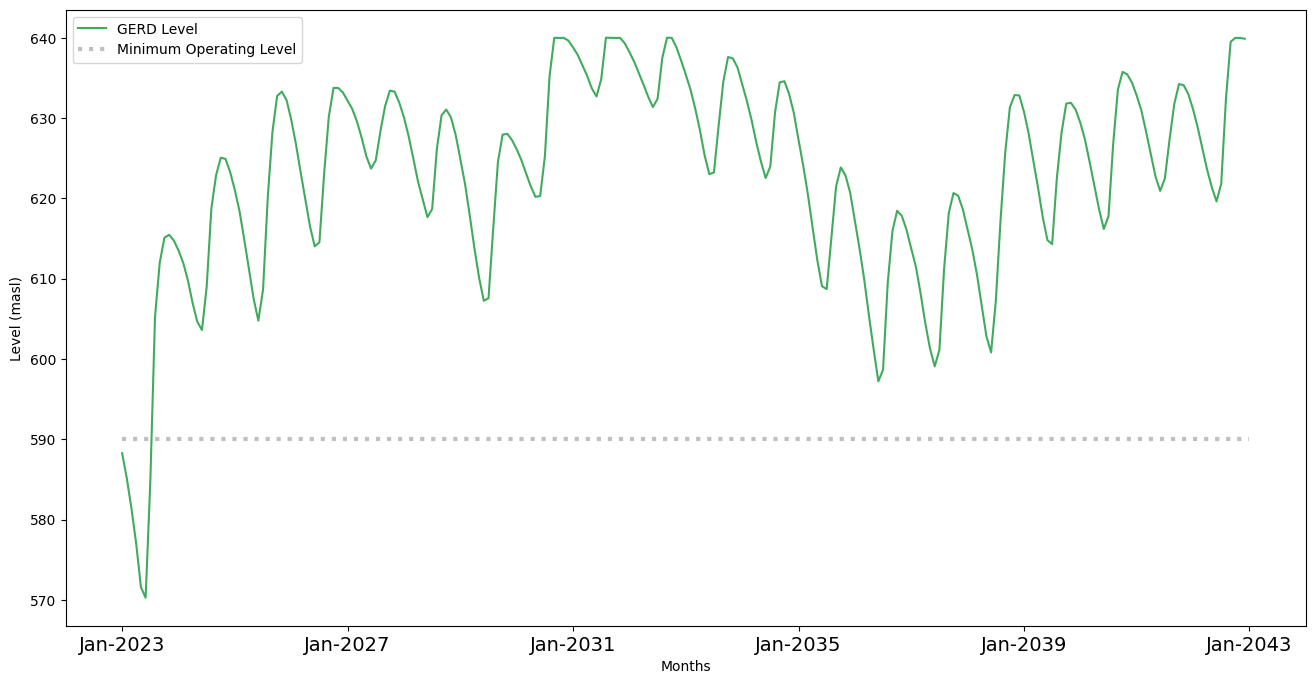

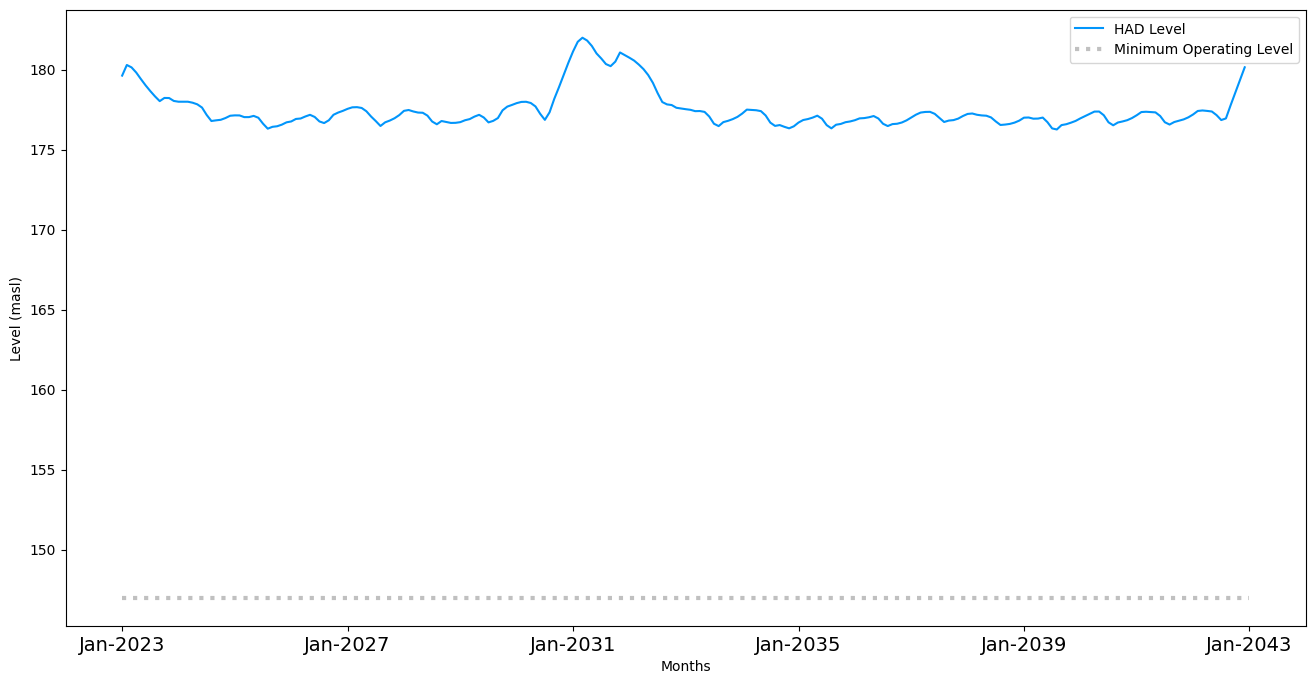

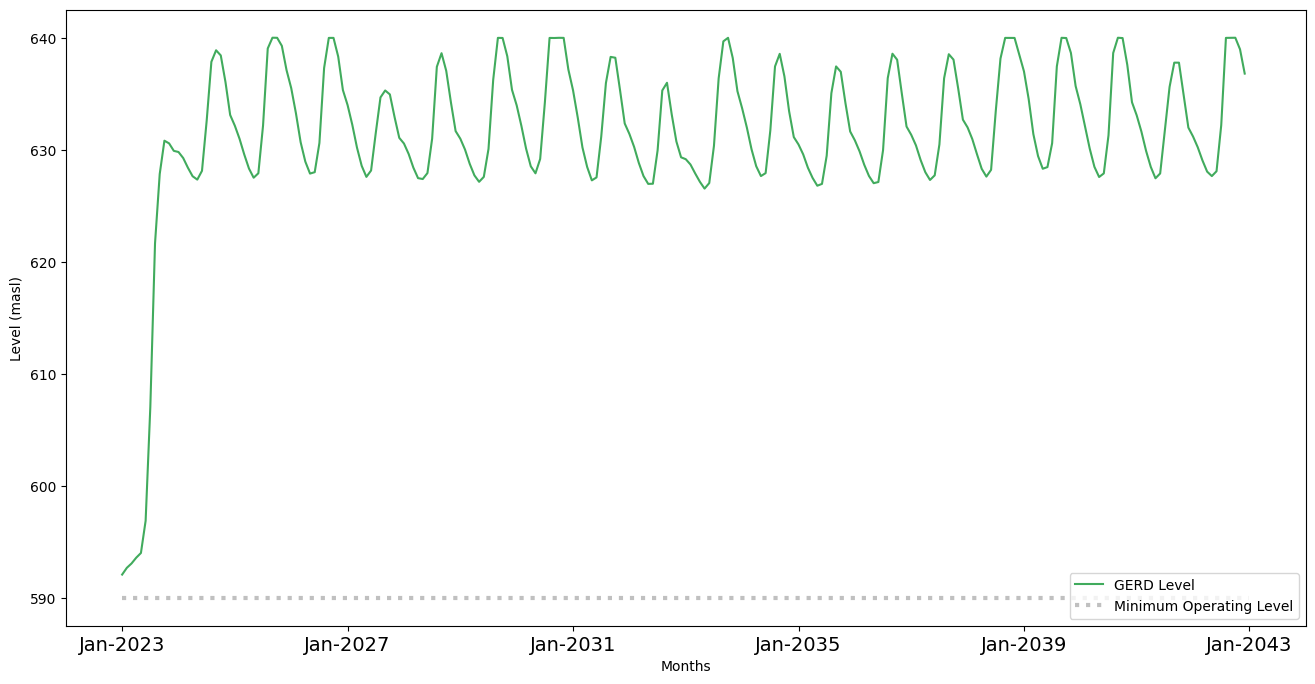

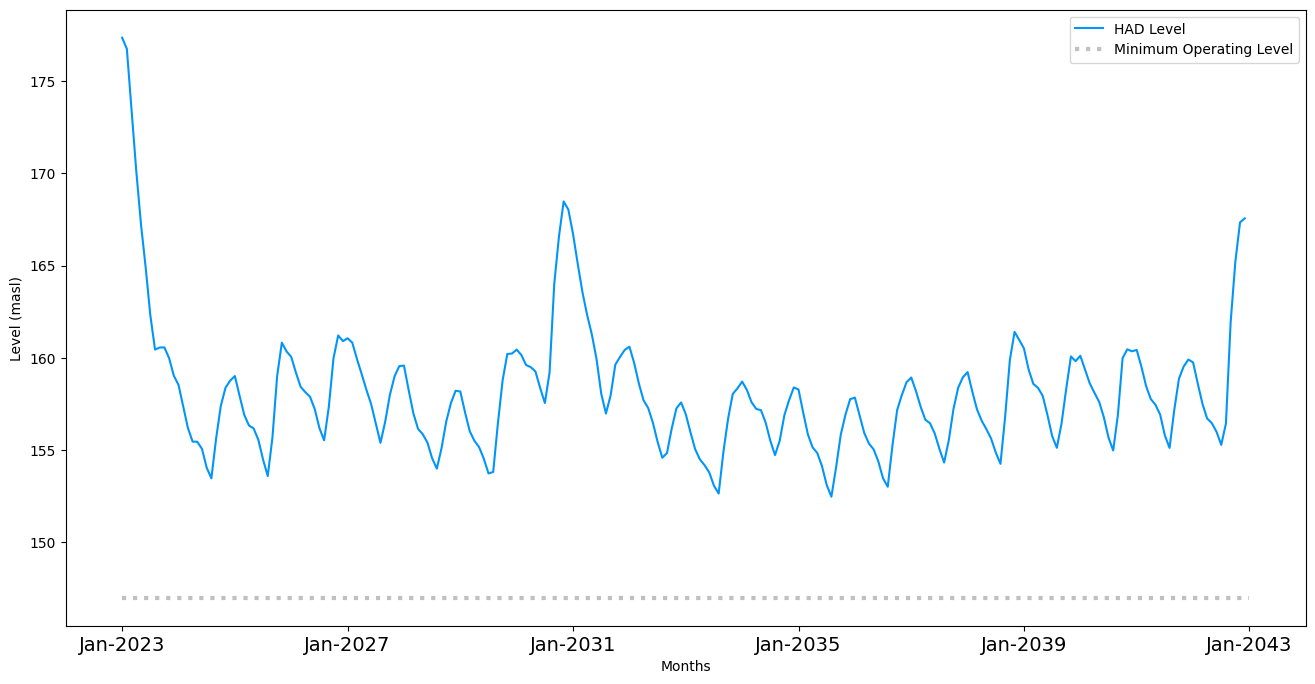

In [18]:
for policy in [best_egypt, percent_compromise, best_ethiopia]:
    new_model.evaluate(policy)
    
    for dam, dam_color, mini, maxi in [("GERD", "#41ab5d", 590, 640), ("HAD", "#0195fb", 147, 185)]:
        fig, ax = plt.subplots(figsize=(16,8))
        for key, value in enumerate([new_model]):
            # print(key)
            if key == 0:
                ax.plot(value.object_by_name(dam).level_vector, color=dam_color, label=f"{dam} Level")
            else:
                ax.plot(value.object_by_name(dam).level_vector, color=dam_color)

        ax.set_xlabel("Months")
        ax.set_ylabel("Level (masl)")
        for i, label, color in [(mini, "Minimum Operating Level", "silver")]:
            ax.hlines(
                                y=i,
                                linewidth=3,
                                xmin=0,
                                xmax=240,
                                label=label,
                                color=color,
                                linestyle=":",
                            )

        ax.set_xticks(
            np.arange(
                0, 20 * 12 + 1, 4 * 12
            )
        )
        ax.set_xticklabels(
            [
                f"Jan-{2023+i*4}"
                for i in range(int(20 / 4) + 1)
            ],
            fontsize=14,
        )

        ax.legend()
        # plt.savefig(f"../plots/baseline_optimization/{dam}_{policy}.pdf", bbox_inches="tight")
        plt.show()

In [15]:
full_return

(3.5823426, 176.26527, 0.0, 12.762398)